# Fluid-Structure Interaction using `Dyn3d` and `Whirl`

## <span style="color:blue"> Include Packages

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

include(Pkg.dir("Dyn3d")*"/src/Dyn3d.jl")
using Dyn3d

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

## <span style="color:blue"> Set up rigid body with Dyn3d

#### Include any joint-body setup script from Dyn3d

In [3]:
include(Pkg.dir("Dyn3d")*"/src/config_files/2dFall.jl")

Config info set up.


#### Build joint-body chain

In [4]:
bs, js, bsys = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bs, js, bsys)

#### Initialize rigid body system state

In [5]:
# initialize system to complete body-joint information
bd, soln = InitSystem!(bd)

# initialize solution structure
solns = (Soln)[]
push!(solns, soln);

This is a 1 body-joint system, system is fixed in space

#### Get body verts for plotting

In [6]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, solns[1].qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

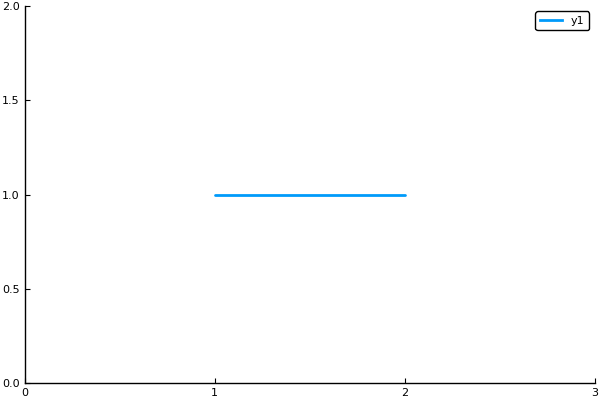

In [7]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,2:3,1], vs₀[i,2:3,2],linewidth=2)
end
plot!(xlims=(0,3), ylims=(0,2))

## <span style="color:blue"> Set up fluid with Whirl </span>

#### Set the flow parameters

In [8]:
Re = 200 # Reynolds number
U = 1.0 # Free stream velocity
U∞ = (U, 0.0)

(1.0, 0.0)

#### Set the domain grid and time step size

In [9]:
nx = 152; ny = 102;
Ly = 2.0;
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re)
w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:3.0100000000000002, -0.01:0.02:2.0100000000000002)

#### Set up initial conditions

In [10]:
t = 0.0
tf = 50*Δt
T = Δt:Δt:tf

w₀ .= 0.0
fx = Float64[]
fy = Float64[]
thist = []
uhist = []
tsample = 0.02;

## <span style="color:blue"> Create fluid-body interface </span>

#### Genrate body grid points and get linear velocity on them

In [11]:
# bgs short for body grid system
bgs = GenerateBodyGrid(bd; np=DetermineNP(nbody, Δx))
bgs = CutOut2d(bd,bgs)
bgs = AcquireBodyGridKinematics(bd,bgs)

coord = hcat(bgs[1].q_i...)'[:,[1,2]]
motion = hcat(bgs[1].v_i...)'[:,[1,2]]
for i = 2:length(bgs)
    coord = [coord[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,2]]]
    motion = [motion[1:end-1,:]; hcat(bgs[i].v_i...)'[:,[1,2]]]
end

#### Variable containers for all stages in IFHERK and HERKBody

In [12]:
# Herk stages for both body and fluid solver
NS = bd.sys.num_params.st
if NS != 3 error("Dyn3d RK scheme not the same with Whirl") end

# Body kinematics container for ifherk input and herkbody output
bkins = Vector{Array{Float64,2}}(NS)

# Body force container for ifherk output(not integrated)
fs = Vector{Array{Float64,2}}(NS)

# Body force container for herkbody input(integrated)
f_exis = [zeros(bd.sys.nbody,6) for i=1:NS]

# All body info container
bds = [bd for i=1:NS];

#### Get body points initial coordinates for fluids

In [13]:
bgs = AcquireBodyGridKinematics(bd,bgs)
coord = hcat(bgs[1].q_i...)'[:,[1,2]]
for i = 2:length(bgs)
    coord = [coord[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,2]]]
end
coord_init = coord;

## <span style="color:blue"> Set up integrators for Time Marching </span>

#### Set up the Navier-Stokes  problem type

In [14]:
X̃ = VectorData(coord_init)
fsys = Whirl.Systems.NavierStokes((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃,
                                 isstore = true, isstatic = false)

Navier-Stokes system on a grid of size 152 x 102

#### Constants for coupling

In [15]:
tol = 5e-4  # coupling tolerance
ω = (config_bodys[1].ρ)/(1.0+config_bodys[1].ρ)  # relaxation parameter

0.5

#### Create Body solver object of type HerkBody

In [16]:
herkbody = Dyn3d.HERKBody(bd.sys.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
            (HERKFuncf,HERKFuncgti),
            (UpdatePosition!,UpdateVelocity!))

Order-3 HERK time-marching function like object for Dyn3d


#### Create Fluid solver object of type IFHERK

In [17]:
u = w₀
f = VectorData(X̃)
fs = [[f.u f.v] for i=1:NS]

# construct fluid solver with uniform constant free stream
ifherk_sc2d = Whirl.IFHERK_sc2d(u,f,fsys.Δt,
                (t,u) -> Systems.plan_intfact(t,u,fsys),
                (u,t,coord) -> Whirl.plan_constraints(u,t,fsys,coord),
                ((u,t) -> Whirl.r₁(u,t,fsys),
                 (u,t,motion) -> Whirl.r₂(u,t,fsys,motion)),
                coord_init,
                tol=1e-3,rk=Whirl.TimeMarching.RK31,
                isstored=true,isstaticconstraints=false)

Order-3 IF-HERK for fs interaction integrator with
   State of type Whirl.Fields.Nodes{Whirl.Fields.Dual,152,102}
   Force of type Whirl.Fields.VectorData{51}
   Time step size 0.01


## <span style="color:blue"> Time Marching! </span>

#### Make timestep in Dyn3d the same with Whirl

In [18]:
soln.dt = Δt
solns[1].dt = soln.dt

# total number of body points in the fluid solver
np_total = round(Int,length(f)/2)

51

#### Proceed with normal coupling AFTER the first timestep

In [19]:
@time for t in T

    iter = 1
    fᵢ = fs.*Δx^2

    # record body info
    soln_buffer = deepcopy(soln)
    bd_buffer = deepcopy(bd)
    bgs_buffer = deepcopy(bgs)

    # record fluid info
    u_buffer = deepcopy(u)
    t_buffer = t

    # interation until coupled
    while true

        #--------------------------------------------------------
        # get body state of the last timestep
        soln = deepcopy(soln_buffer)
        bd = deepcopy(bd_buffer)
        bgs = deepcopy(bgs_buffer)

        #--------------------------------------------------------
        # integrate body forces from body points
        for k = 1:NS
            b_cnt = 1
            ref = 0
            for i = 1:np_total
                # move to the next bgs if i exceed bgs[b_cnt].np
                if i > ref + bgs[b_cnt].np
                    ref += bgs[b_cnt].np
                    b_cnt += 1        
                end
                bgs[b_cnt].f_ex3d[i-ref][[1,2]] = fᵢ[k][i,:]
            end

            # integrate total forces from all body points on a body
            bgs = IntegrateBodyGridDynamics(bd,bgs)
            for i = 1:bd.sys.nbody
                f_exis[k][i,:] = bgs[i].f_ex6d
            end
        end
        
        #--------------------------------------------------------
        # advance body solver for one step        
        soln, bds = herkbody(soln, bd; _isfixedstep=true, _outputmode=true, f_exi=f_exis);

        #--------------------------------------------------------
        # acquire coord and motion(velocity) of body points for fluid computation
        for k = 1:NS
            bgs = AcquireBodyGridKinematics(bds[k],bgs)
            coord = hcat(bgs[1].q_i...)'[:,[1,2]]
            motion = hcat(bgs[1].v_i...)'[:,[1,2]]
            for i = 2:length(bgs)
                coord = [coord[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,2]]]
                motion = [motion[1:end-1,:]; hcat(bgs[i].v_i...)'[:,[1,2]]]
            end
            bkins[k] = [coord motion]
        end
        
        #--------------------------------------------------------
        # get fluid state of the last timestep
        u = deepcopy(u_buffer)
        t = t_buffer

        #--------------------------------------------------------
        # advance fluid solver for one step
        t, u, f, fs = ifherk_sc2d(t,u,bkins)

        #--------------------------------------------------------
        # check if converge, use relaxation if not
        ϵ = abs(sum(fs[NS]*Δx^2 - fᵢ[NS]))
        if ϵ < tol break end

#         println("proposed fy at last stage: ", sum(fᵢ[NS][:,2]))
#         println("corrected fy at last stage: ", sum(fs[NS][:,2])*Δx^2)
        
        # if not converge, use relaxation
        fᵢ = (1-ω)*fᵢ + ω*fs*Δx^2
        
#         println("relaxation fy at last stage: ", sum(fᵢ[NS][:,2]),"\n")
#         println("iteration ",iter,", ϵ = ",ϵ)
        iter += 1   
        
    end
    
    # converged for this timestep
    print("time = ", t-Δt, " converged through ", iter, " iterations\n")
    
    # record converged bd for next step
    bd = bds[NS]
    
    # record body solution for this timestep
    push!(solns, soln)

    # record fluid solution for this timestep
    push!(thist,t)
    push!(fx,sum(fᵢ[NS][:,1]))
    push!(fy,sum(fᵢ[NS][:,2]))
    push!(uhist,deepcopy(u))
    
end

time = 0.01 converged through 14 iterations
time = 0.019999999999999997 converged through 14 iterations
time = 0.03 converged through 9 iterations
time = 0.04 converged through 9 iterations
time = 0.05 converged through 9 iterations
time = 0.05999999999999999 converged through 9 iterations
time = 0.07 converged through 9 iterations
time = 0.08 converged through 8 iterations
time = 0.09 converged through 8 iterations
time = 0.1 converged through 8 iterations
time = 0.11 converged through 8 iterations
time = 0.12000000000000001 converged through 8 iterations
time = 0.13 converged through 8 iterations
time = 0.14 converged through 8 iterations
time = 0.15 converged through 8 iterations
time = 0.16 converged through 8 iterations
time = 0.17 converged through 8 iterations
time = 0.18 converged through 8 iterations
time = 0.19 converged through 8 iterations
time = 0.2 converged through 8 iterations
time = 0.21 converged through 8 iterations
time = 0.22 converged through 8 iterations
time = 0

## <span style="color:blue"> Plot </span>

#### Set contour levels and gif name

In [30]:
contour_levels = linspace(-0.2,0.2,30)
gif_name = "template_test.gif"
fps = 20;

#### Get body verts history

In [21]:
@get bd (bs, js, sys)
vshist = []
for i = 1:length(solns)
    bs, js, sys = UpdatePosition!(bs, js, sys, solns[i].qJ)
    push!(vshist, VertsHistory(sys.nbody, bs))
end

#### Plot first and last time field

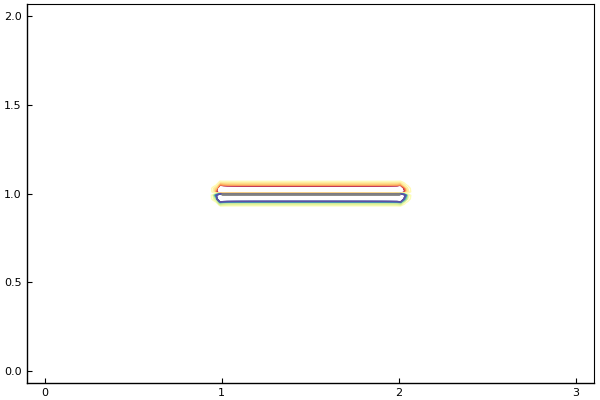

/home/julia/JuliaPro-0.6.2.2/JuliaPro/pkgs-0.6.2.2/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'label'
  s)


In [22]:
p1 = plot(xg,yg,uhist[1],levels=contour_levels)
for i = 1:sys.nbody
    plot!(p1,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="grey")
end
p1

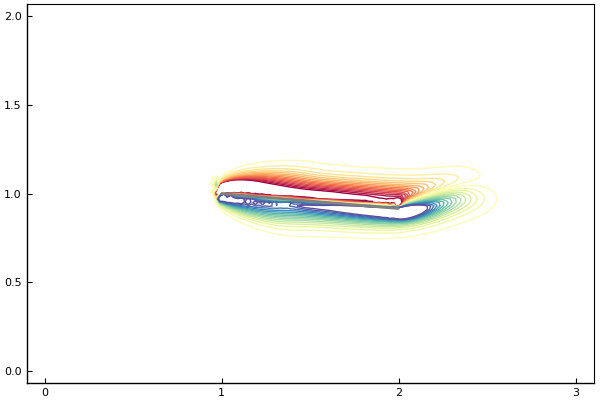

In [31]:
p2 = plot(xg,yg,uhist[end],levels=contour_levels)
for i = 1:sys.nbody
    plot!(p2,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="grey")
end
p2

#### Body position at t=0 and t=tf

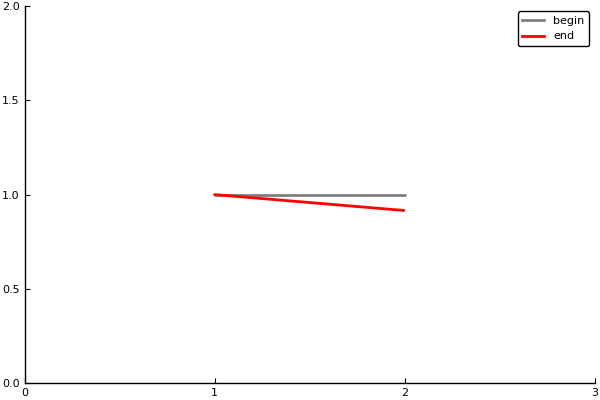

In [24]:
pb = plot()
for i = 1:sys.nbody
    plot!(pb,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="grey",label="begin")
end
for i = 1:sys.nbody
    plot!(pb,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="red",label="end")
end
plot!(pb,xlims=(0,3), ylims=(0,2))
pb

#### Make a gif

In [32]:
anim = @animate for j = 1:length(uhist)
    plot(xg,yg,uhist[j],levels=contour_levels)
    for i = 1:sys.nbody
        plot!(vshist[j][i,2:3,1], vshist[j][i,2:3,2],linewidth=2,linecolor="grey")
    end
end

gif(anim, "movies/"*gif_name, fps = fps)

INFO: Saved animation to /media/ruizhi/Seagate Expansion Drive/Research/Dyn3d.jl/notebook/movies/template_test.gif


Plots.AnimatedGif("/media/ruizhi/Seagate Expansion Drive/Research/Dyn3d.jl/notebook/movies/template_test.gif")

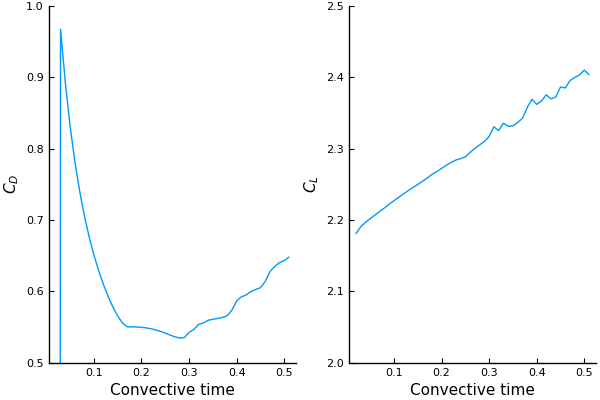

In [37]:
px = plot(thist,2*fx,ylim=(0.5,1.0),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(2.0,2.5),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

## <span style="color:blue"> Save Data </span>

#### Save all current data related to plotting to a .jld file

In [27]:
filename = "template_test.jld";

In [34]:
using JLD

save("saved_data/"*filename,
    "bd", bd,
    "xg", xg,
    "yg", yg,
    "uhist", uhist,
    "vshist", vshist,
    "thist", thist,
    "fx", fx,
    "fy", fy,
    "solns", solns
)

#### Use the following block to extract data when re-open this notebook

In [29]:
# using Whirl, Dyn3d, Plots, JLD

# pyplot()
# clibrary(:colorbrewer)
# default(grid = false)

# d = load("saved_data/template_test.jld")
# thist = d["thist"]
# fx = d["fx"]
# fy = d["fy"]
# xg = d["xg"]
# yg = d["yg"]
# vshist = d["vshist"]
# solns = d["solns"]
# uhist = d["uhist"]
# bd = d["bd"]

# @get bd (bs,js,sys);